In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# # from jlinops import CGPseudoinverse, MatrixOperator
# from jlinops import MatrixLinearOperator, QRPinvOperator
# from scipy.linalg import null_space

# from scipy.sparse.linalg import cg as scipy_cg
# from jlinops import cg

# from scipy.linalg import qr as scipy_qr
# from scipy.linalg import solve_triangular as scipy_solve_triangular
# #from scipy.sparse.linalg._interface import MatrixLinearOperator, _CustomLinearOperator
# import scipy.sparse as sps

# from scipy.sparse import diags
# # from jlinops import SparseMatrixOperator

# from jlinops import CGWeightedNeumann2DPinvOperator
# #from jlinops import CGWeightedDiscreteGradientNeumann2DPseudoinverse

In [2]:
import numpy as np
import math

from scipy.linalg import solve_triangular as scipy_solve_triangular
from scipy.linalg import qr as sp_qr
from scipy.linalg import solve_triangular as sp_solve_triangular
from scipy.sparse.linalg import SuperLU as sp_SuperLU
from scipy.sparse.linalg import cg as sp_cg
import scipy.sparse as sps

import jlinops


from jlinops import MatrixLinearOperator, _CustomLinearOperator 
from jlinops import banded_cholesky
from jlinops import DiagonalOperator
from jlinops import Neumann2D
from jlinops import dct_sqrt_pinv, dct_pinv
from jlinops import cg
from jlinops import issparse, tosparse, get_device
from jlinops import QRPinvOperator


from jlinops import CUPY_INSTALLED
if CUPY_INSTALLED:
    import cupy as cp
    from cupyx.scipy.linalg import solve_triangular as cp_solve_triangular
    from cupy.linalg import qr as cp_qr
    from cupyx.scipy.sparse.linalg import SuperLU as cp_SuperLU



In [3]:
class CGPreconditionedPinvModOperator(_CustomLinearOperator):
    """Returns a linear operator that approximately computes the pseudoinverse of a matrix A using 
    a conjugate gradient method. Modifed so that it only ever solves systems with A^T A. 
    
    W: a LinearOperator representing a matrix with linearly independent columns that spans null(A).
    Wpinv: a LinearOperator represening the pseudoinverse of W.
    Lpinv: 
    """

    def __init__(self, A, W, Wpinv, Mpinv, warmstart_prev=True, check=False, which="scipy", *args, **kwargs):

        assert which in ["jlinops", "scipy"], "Invalid choice for which!"

        # Device
        device = A.device
        
        # Store operator
        self.A = A
        self.W = W
        self.Wpinv = Wpinv
        self.Mpinv = Mpinv
        
        # Shape
        m, n = A.shape
        shape = (n, m)

        # Setup
        self.which = which
        self.check = check
        self.warmstart_prev = warmstart_prev
        self.in_shape = self.A.shape[0]
        self.out_shape = self.A.shape[1]
        
        if device == "cpu":
            self.prev_eval = np.zeros(self.out_shape)
            self.prev_eval_t = np.zeros(self.out_shape)
        else:
            self.prev_eval = cp.zeros(self.out_shape)
            self.prev_eval_t = cp.zeros(self.out_shape)

        # Build both operators we need
        self.C = self.A.T @ self.A
        self.MpinvC = self.Mpinv @ self.C

        
        if device == "cpu":
            
           
            if self.which == "scipy":
                
                def _matvec(x):
                    sol, converged = sp_cg(self.C, self.A.rmatvec(x), x0=self.prev_eval, M=self.Mpinv, *args, **kwargs) 
                    if self.check:
                        assert converged == 0, "CG algorithm did not converge!"
                    
                    if self.warmstart_prev:
                        self.prev_eval = sol.copy()
                    
                    return sol
                
                def _rmatvec(x):
                    
                    # Project x onto range(A^T A) = range(A^T).
                    z = x - (self.W @ (self.Wpinv @ x))
                    
                    sol, converged = sp_cg(self.C, z, x0=self.prev_eval_t, M=self.Mpinv, *args, **kwargs) 
                    if self.check:
                        assert converged == 0, "CG algorithm did not converge!"
                    
                    if self.warmstart_prev:
                        self.prev_eval_t = sol.copy()
                    
                    return self.A @ sol
                
            else:
                raise NotImplementedError
                
        else:
            
            if self.which == "scipy":
                
                def _matvec(x):
                    sol, converged = cupy_cg(self.C, self.A.rmatvec(x), M=self.Mpinv, x0=self.prev_eval, *args, **kwargs)
                    if self.check:
                        assert converged == 0, "CG algorithm did not converge!"
                    
                    if self.warmstart_prev:
                        self.prev_eval = sol.copy()
                        
                    return sol
                
                def _rmatvec(x):
                    
                    # Project x onto range(A^T A) = range(A^T).
                    z = x - (self.W @ (self.Wpinv @ x))
                    
                    sol, converged = cupy_cg(self.C, z, x0=self.prev_eval_t, M=self.Mpinv, *args, **kwargs) 
                    if self.check:
                        assert converged == 0, "CG algorithm did not converge!"
                    
                    if self.warmstart_prev:
                        self.prev_eval_t = sol.copy()
                        
                    return self.A @ sol
                
            else:
                raise NotImplementedError
        
        
        super().__init__( shape, _matvec, _rmatvec, dtype=np.float64, device=device)
        
        
    def to_gpu(self):
        return CGPreconditionedPinvModOperator(self.A.to_gpu(), self.W.to_gpu(), self.Wpinv.to_gpu(), self.Mpinv.to_gpu(), warmstart_prev=self.warmstart_prev, which=self.which, check=self.check, *self.args, **self.kwargs)
    
        
    def to_cpu(self):
        return CGPreconditionedPinvModOperator(self.A.to_cpu(), self.W.to_cpu(), self.Wpinv.to_cpu(), self.Mpinv.to_cpu(), warmstart_prev=self.warmstart_prev, which=self.which, check=self.check, *self.args, **self.kwargs)
    
    

In [4]:

class CGWeightedNeumann2DPinvOperator(_CustomLinearOperator):
    """Represents the pseudoinverse (R_w)^\dagger of a linear operator R_w = D_w R, where
    D_w is a diagonal matrix of weights and R is a Neumann2D operator.
    Here matvecs/rmatvecs are applied approximately using a preconditioned conjugate
    gradient method, where the preconditioner is based on the operator with identity weights. 
    """

    def __init__(self, grid_shape, weights, warmstart_prev=True, check=False, which="scipy", dct_eps=1e-14, *args, **kwargs):

        assert 2*math.prod(grid_shape) == len(weights), "Weights incompatible!"
        self.weights = weights
        self.grid_shape = grid_shape
        self.warmstart_prev = warmstart_prev
        self.check = check
        self.which = which
        self.args = args
        self.kwargs = kwargs
        
        # Figure out device
        device = get_device(weights)

        # Build R and R_w
        self.R = Neumann2D(grid_shape, device=device)
        self.RtR = self.R.T @ self.R
        self.Dw = DiagonalOperator(weights)
        self.Rw = self.Dw @ self.R

        # Get Rpinv (with identity weights)
        self.RtRpinv = dct_pinv( self.RtR, grid_shape, eps=dct_eps )

        # Take care of W (columns span the kernel of R)
        if device == "cpu":
            W = np.ones((self.R.shape[1],1))
        else:
            W = cp.ones((self.R.shape[1],1))
            
        self.W = MatrixLinearOperator(W)
        self.Wpinv = QRPinvOperator(self.W)

        # Make Rwpinv
        self.Rwpinv = CGPreconditionedPinvModOperator(self.Rw, self.W, self.Wpinv, self.RtRpinv, warmstart_prev=warmstart_prev, check=check, which=which, *args, **kwargs)

        def _matvec(x):
            return self.Rwpinv.matvec(x)

        def _rmatvec(x):
            return self.Rwpinv.rmatvec(x)

        super().__init__( self.Rwpinv.shape, _matvec, _rmatvec, dtype=np.float64, device=device)
        

    def to_gpu(self):
        return CGWeightedNeumann2DPinvOperator(self.grid_shape, cp.asarray(self.weights), warmstart_prev=self.warmstart_prev, check=self.check, which=self.which, *self.args, **self.kwargs)
    
    def to_cpu(self):
        return CGWeightedNeumann2DPinvOperator(self.grid_shape, cp.numpy(self.weights), warmstart_prev=self.warmstart_prev, check=self.check, which=self.which, *self.args, **self.kwargs)
    

In [54]:
from scipy.stats import arcsine

In [61]:
m, n = 10, 12
#w = np.random.uniform(low=1, high=10, size=2*m*n)
w = 0.1*arcsine.rvs(size=2*m*n)
Apinv = CGWeightedNeumann2DPinvOperator((m,n), 1.0/np.sqrt(w) , tol=1e-8)

In [62]:
R = Neumann2D((m,n))
WR = DiagonalOperator(1.0/np.sqrt(w)) @ R 
WR_mat = jlinops.black_box_to_dense(WR)
WRpinv = np.linalg.pinv(WR_mat)

In [63]:
for j in range(100):
    rand_vec = np.random.normal(size=2*m*n)
    err = np.linalg.norm( (WRpinv @ rand_vec) - (Apinv @ rand_vec) )
    print(err)

4.579532754901743e-08
6.191668578539321e-08
6.347215103196493e-08
5.7164075038205774e-08
4.4509799293447094e-07
5.7797775966432846e-08
5.244459561940375e-08
1.774987441687685e-07
9.800752364571794e-08
7.320215355357769e-08
4.3761785295572054e-08
2.6141257899038786e-07
6.849079956325702e-08
1.3645292102732993e-07
5.0607356429916634e-08
3.7803438560922556e-07
1.3670748428776241e-07
2.3724484677515998e-07
5.247913878739616e-08
1.1762322639017769e-07
1.0046732822794789e-07
1.2997187748775426e-07
2.864237100256239e-08
5.754073813245499e-08
2.6739864901800913e-08
8.535885767121873e-08
2.0216563693358197e-07
7.366968030019789e-08
1.5353444983864737e-07
7.675684222690201e-08
4.868966549110354e-08
7.587559307616142e-08
4.7184115374950713e-07
3.0049377716919274e-08
7.19028099966299e-08
1.9044324321308857e-07
1.2610549912785943e-07
1.218236251513335e-07
2.706548868768179e-07
1.0797853105714096e-07
3.109988021405906e-08
1.165853861498178e-07
1.0172788113454843e-07
3.669284289127092e-08
1.070440008

In [49]:
# m, n = 250, 250
m, n = 20, 20
w = np.random.uniform(low=1, high=500, size=2*m*n)
Apinv = CGWeightedNeumann2DPinvOperator((m,n), 1.0/np.sqrt(w) , tol=1e-8)
R = Neumann2D((m,n))
WR = DiagonalOperator(1.0/np.sqrt(w)) @ R

In [50]:
Rspmat = jlinops.build_neumann2d_sparse_matrix((m,n))

In [51]:
WRspmat = sps.diags(1.0/np.sqrt(w)) @ Rspmat

In [52]:
WRpinv = np.linalg.pinv(WRspmat.toarray())

In [53]:
for j in range(100):
    rand_vec = np.random.normal(size=2*m*n)
    tmp = Apinv @ rand_vec

    #print(np.linalg.norm( (WR @ _) - rand_vec  ))

    err = np.linalg.norm( (WRpinv @ rand_vec) - (tmp) )
    print(err)

2.6047282683367636e-06
2.3176089736815755e-06
1.8753289161939432e-06
2.27124544135164e-06
2.132959057290208e-06
1.5256371729790208e-06
2.173843941736648e-06
3.1126081607710893e-06
1.3266173114303941e-06
2.5452305681490284e-06
2.070277456609867e-06
2.034404469536805e-06
1.7683606405267489e-06
1.8258228604636953e-06
1.7066240409318208e-06
2.5123701216027412e-06
2.587890461812101e-06
1.973133911891711e-06
1.657750329713401e-06
1.8676603348189288e-06
2.2727060311298445e-06
1.929485669631979e-06
1.6782077489525555e-06
1.9187295305248438e-06
2.1216571527272624e-06
2.5224642529999308e-06
2.5706525935621843e-06
1.5691318430912872e-06
1.925347465387884e-06
2.1331832785734594e-06
1.6307306114336168e-06
1.6680434590938478e-06
1.7290569886531259e-06
1.8493507745807084e-06
2.919109495887843e-06
1.347923325367587e-06
1.6966666750834367e-06
2.0383756683580964e-06
3.023114221728357e-06
2.025110525229883e-06
1.8320157046408128e-06
2.0261228632919303e-06
1.9814760886261755e-06
2.3971797074040384e-06
1.7

In [69]:
%%timeit
rand_vec = np.random.normal(size=2*m*n)
_ = Apinv @ rand_vec

438 ms ± 198 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# m, n = 250, 250
m, n = 40, 40
w = np.random.uniform(low=1, high=10, size=2*m*n)
Apinv = CGWeightedNeumann2DPinvOperator((m,n), 1.0/np.sqrt(w) , tol=1e-8)
R = Neumann2D((m,n))
WR = DiagonalOperator(1.0/np.sqrt(w)) @ R

In [26]:
import matplotlib.pyplot as plt

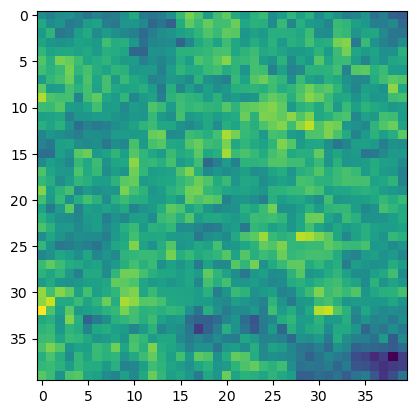

In [27]:
plt.imshow(tmp.reshape((m,n)))
plt.show()

In [53]:
# R = Neumann2D((m,n))
# WR = DiagonalOperator(1.0/np.sqrt(w)) @ R 
# WR_mat = jlinops.black_box_to_dense(WR)
# WRpinv = np.linalg.pinv(WR_mat)